In [133]:
# import os
# import json
# import glob
# import copy

# import numpy as np
# import pylab as pl
# import seaborn as sns
# import pandas as pd
# import cPickle as pkl

# from scipy import stats as spstats

# from pipeline.python.classifications import experiment_classes as util
# from pipeline.python.utils import natural_keys, label_figure
# from pipeline.python.classifications import aggregate_data_stats as aggr
# from pipeline.python.retinotopy import fit_2d_rfs as fitrf
# from pipeline.python.classifications import evaluate_receptivefield_fits as evalrfs
# from pipeline.python.classifications import retino_structure as ret

# import itertools
# import statsmodels as sm

import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.utils import natural_keys, label_figure, convert_range

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrfs
from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import rf_utils as rfutils


In [2]:
%matplotlib notebook

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Set dataset params

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff
DATA ID: traces001|fit-2dgaus_dff-no-cutoff-thr-0.50


# Select datasets

In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)


# Load dataframes

In [131]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

In [104]:
filter_by = 'drop_repeats'
scale_sigma = True
data_id = '%s|%s' % (data_id, filter_by)

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, scale_sigma=scale_sigma, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    if 'rfs10' in g.experiment.values and 'rfs' in g.experiment.values:
        expname = 'rfs' if visual_area=='V1' else 'rfs10'
    else:
        expname = 'rfs' if 'rfs' in g.experiment.values else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    vdf = g[g['experiment']==expname]
    rdf_list.append(vdf)
df = pd.concat(rdf_list)

#### Filter for good fits only
df = df[df['r2']>fit_thr]
df.groupby(['visual_area']).count()
    
#### Split fx, fy for theta comp
fx = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.cos(df['theta']))
fy = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy

Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4
20190502_JC076_fov1
20190522_JC089_fov1
20190522_JC089_fov1
20190605_JC090_fov1
20190607_JC091_fov1
20190614_JC091_fov1
20191007_JC091_fov1
20191007_JC091_fov1
20191008_JC091_fov1
20190527_JC092_fov2
20190527_JC092_fov3
20190528_JC092_fov1
20190612_JC099_fov1
20190617_JC099_fov1
20191003_JC111_fov1
20191018_JC113_fov1
20191105_JC117_fov1
20191111_JC120_fov1
20190423_JC076_fov1
20190509_JC078_fov1
20190513_JC078_fov1
20190602_JC080_fov2
***ERROR: 20190602_JC080_fov2
20190603_JC080_fov1


Traceback (most recent call last):
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py", line 172, in aggregate_rf_data
    col_vals=fit_results['col_vals'], roi_list=fit_rois)
  File "/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py", line 63, in rfits_to_df
    rf_fits_df = pd.DataFrame({'x0': [rffits[r]['x0'] for r in roi_list],
KeyError: 133


20190517_JC083_fov1
20190525_JC084_fov1
20190627_JC091_fov1
20190618_JC097_fov1
20190618_JC097_fov1
20191004_JC110_fov3
20191004_JC110_fov4
20191012_JC113_fov3
20191104_JC117_fov2
20191111_JC117_fov2
20191106_JC120_fov4
20190420_JC076_fov1
20190511_JC083_fov1
20190522_JC084_fov1
20190622_JC085_fov1
20190622_JC085_fov1
20190613_JC097_fov1
20190613_JC097_fov1
20190616_JC097_fov1
20190616_JC097_fov1
20190617_JC097_fov1
20191006_JC110_fov1
20191006_JC110_fov1
20191111_JC117_fov1
20191106_JC120_fov3


In [134]:
df.groupby(['visual_area', 'datakey', 'experiment']).count()


r2  sigma_x  sigma_y  theta  x0  \
visual_area datakey             experiment                                    
Li          20190502_JC076_fov1 rfs         12       12       12     12  12   
            20190522_JC089_fov1 rfs10        8        8        8      8   8   
            20190527_JC092_fov2 rfs10       14       14       14     14  14   
            20190527_JC092_fov3 rfs10       45       45       45     45  45   
            20190528_JC092_fov1 rfs10        8        8        8      8   8   
            20190605_JC090_fov1 rfs10       13       13       13     13  13   
            20190607_JC091_fov1 rfs10       61       61       61     61  61   
            20190612_JC099_fov1 rfs10       44       44       44     44  44   
            20190614_JC091_fov1 rfs10       84       84       84     84  84   
            20190617_JC099_fov1 rfs10       16       16       16     16  16   
            20191003_JC111_fov1 rfs10        9        9        9      9   9   
            20191007_JC091_fov1 rfs10       19       19       19     19  19   
            20191008_JC091_fov1 rfs10       34       34       34     34  34   
            20191018_JC113_fov1 rfs10       15       15       15     15  15   
            20191105_JC117_fov1 rfs10       12       12       12     12  12   
            20191111_JC120_fov1 rfs10        4        4        4      4   4   
Lm          20190423_JC076_fov1 rfs         14       14       14     14  14   
            20190509_JC078_fov1 rfs         11       11       11     11  11   
            20190513_JC078_fov1 rfs         22       22       22     22  22   
            20190517_JC083_fov1 rfs         14       14       14     14  14   
            20190525_JC084_fov1 rfs         34       34       34     34  34   
            20190603_JC080_fov1 rfs         48       48       48     48  48   
            20190618_JC097_fov1 rfs10       20       20       20     20  20   
            20190627_JC091_fov1 rfs         12       12       12     12  12   
            20191004_JC110_fov3 rfs10       10       10       10     10  10   
            20191004_JC110_fov4 rfs10       17       17       17     17  17   
            20191012_JC113_fov3 rfs10       18       18       18     18  18   
            20191104_JC117_fov2 rfs10       46       46       46     46  46   
            20191106_JC120_fov4 rfs10       10       10       10     10  10   
            20191111_JC117_fov2 rfs10        2        2        2      2   2   
V1          20190420_JC076_fov1 rfs         45       45       45     45  45   
            20190511_JC083_fov1 rfs         45       45       45     45  45   
            20190522_JC084_fov1 rfs         91       91       91     91  91   
            20190613_JC097_fov1 rfs         61       61       61     61  61   
            20190616_JC097_fov1 rfs         75       75       75     75  75   
            20190617_JC097_fov1 rfs         63       63       63     63  63   
            20190622_JC085_fov1 rfs         64       64       64     64  64   
            20191006_JC110_fov1 rfs         54       54       54     54  54   
            20191106_JC120_fov3 rfs10       54       54       54     54  54   
            20191111_JC117_fov1 rfs10       15       15       15     15  15   

                                            y0  animalid  cell  fovnum  \
visual_area datakey             experiment                               
Li          20190502_JC076_fov1 rfs         12        12    12      12   
            20190522_JC089_fov1 rfs10        8         8     8       8   
            20190527_JC092_fov2 rfs10       14        14    14      14   
            20190527_JC092_fov3 rfs10       45        45    45      45   
            20190528_JC092_fov1 rfs10        8         8     8       8   
            20190605_JC090_fov1 rfs10       13        13    13      13   
            20190607_JC091_fov1 rfs10       61        61    61      61   
            20190612_JC099_fov1 rfs10       44        44   

## How many cells w/ RF fits per area and per dataset?

In [110]:
counts_by_fov = df.groupby(['visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()

<IPython.core.display.Javascript object>


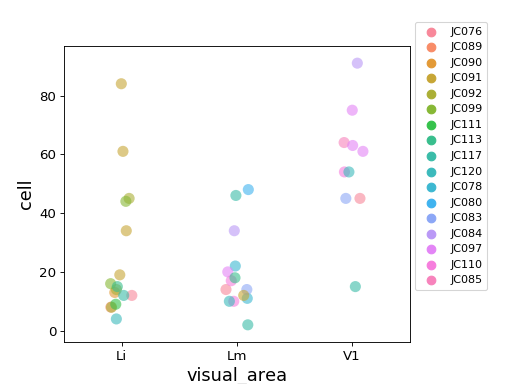

,animalid,datakey,cell
visual_area,,,
Li,16,16,16
Lm,14,14,14
V1,10,10,10


In [130]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='cell', data=counts_by_fov, ax=ax,
             hue='animalid', size=10, alpha=0.6)
ax.legend(bbox_to_anchor=(1, 1.1))
pl.subplots_adjust(right=0.8)

counts_by_fov.groupby(['visual_area']).count()

In [95]:
df['visual']

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,avg_size,datakey_ix,fx,fy
13,0.592816,31.508973,26.952935,-0.288729,12.200497,0.748017,JC089,113,20190522_JC089_fov1,rfs10,1,20190522,Li,29.230954,1,15.102356,4.485833
14,0.554771,45.803545,23.522941,-0.994947,-51.552794,10.413053,JC089,11,20190522_JC089_fov1,rfs10,1,20190522,Li,34.663243,1,12.471108,19.208401
15,0.512692,26.869516,13.283750,-0.673435,4.479900,0.366059,JC089,80,20190522_JC089_fov1,rfs10,1,20190522,Li,20.076633,1,10.501731,8.378925
16,0.571984,36.391638,23.446772,0.513668,8.736586,1.810410,JC089,145,20190522_JC089_fov1,rfs10,1,20190522,Li,29.919205,1,15.847614,8.940970
17,0.800984,31.217329,34.443547,-0.968406,4.725769,11.074534,JC089,116,20190522_JC089_fov1,rfs10,1,20190522,Li,32.830438,1,9.758087,14.190462


In [96]:
full_stimuli = []
for (visual_area, animalid, session, fovnum), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    sd = sdata[(sdata['visual_area']==visual_area) 
                  & (sdata['animalid']==animalid) 
                  & (sdata['session']==session) 
                  & (sdata['fovnum']==fovnum)]
    
    if 'gratings' in sd['experiment'].values and 'blobs' in sd['experiment'].values:
        full_stimuli.append(g['datakey'].unique()[0])
        


In [97]:
full_stimuli

['20190605_JC090_fov1',
 '20190607_JC091_fov1',
 '20190614_JC091_fov1',
 '20191008_JC091_fov1',
 '20190612_JC099_fov1',
 '20190617_JC099_fov1',
 '20191018_JC113_fov1',
 '20191105_JC117_fov1',
 '20191111_JC120_fov1',
 '20190618_JC097_fov1',
 '20190511_JC083_fov1',
 '20190522_JC084_fov1',
 '20190622_JC085_fov1',
 '20190613_JC097_fov1',
 '20190616_JC097_fov1',
 '20190617_JC097_fov1',
 '20191006_JC110_fov1']

In [77]:
sd['experiment'].values

array(['rfs', 'rfs10', 'gratings', 'blobs', 'retino'], dtype=object)

In [98]:
df[df['datakey'].isin(full_stimuli)].groupby(['visual_area', 'datakey']).count()

r2  sigma_x  sigma_y  theta  x0  y0  \
visual_area datakey                                                    
Li          20190605_JC090_fov1  13       13       13     13  13  13   
            20190607_JC091_fov1  61       61       61     61  61  61   
            20190612_JC099_fov1  44       44       44     44  44  44   
            20190614_JC091_fov1  84       84       84     84  84  84   
            20190617_JC099_fov1  16       16       16     16  16  16   
            20191008_JC091_fov1  34       34       34     34  34  34   
            20191018_JC113_fov1  15       15       15     15  15  15   
            20191105_JC117_fov1  12       12       12     12  12  12   
            20191111_JC120_fov1   4        4        4      4   4   4   
Lm          20190618_JC097_fov1  20       20       20     20  20  20   
V1          20190511_JC083_fov1  45       45       45     45  45  45   
            20190522_JC084_fov1  90       90       90     90  90  90   
            20190613_JC097_fov1  61       61       61     61  61  61   
            20190616_JC097_fov1  75       75       75     75  75  75   
            20190617_JC097_fov1  63       63       63     63  63  63   
            20190622_JC085_fov1  64       64       64     64  64  64   
            20191006_JC110_fov1  54       54       54     54  54  54   

                                 animalid  cell  experiment  fovnum  session  \
visual_area datakey                                                            
Li          20190605_JC090_fov1        13    13          13      13       13   
            20190607_JC091_fov1        61    61          61      61       61   
            20190612_JC099_fov1        44    44          44      44       44   
            20190614_JC091_fov1        84    84          84      84       84   
            20190617_JC099_fov1        16    16          16      16       16   
            20191008_JC091_fov1        34    34          34      34       34   
            20191018_JC113_fov1        15    15          15      15       15   
            20191105_JC117_fov1        12    12          12      12       12   
            20191111_JC120_fov1         4     4           4       4        4   
Lm          20190618_JC097_fov1        20    20          20      20       20   
V1          20190511_JC083_fov1        45    45          45      45       45   
            20190522_JC084_fov1        90    90          90      90       90   
            20190613_JC097_fov1        61    61          61      61       61   
            20190616_JC097_fov1        75    75          75      75       75   
            20190617_JC097_fov1        63    63          63      63       63   
            20190622_JC085_fov1        64    64          64      64       64   
            20191006_JC110_fov1        54    54          54      54       54   

                                 avg_size  datakey_ix  fx  fy  
visual_area datakey                                            
Li          20190605_JC090_fov1        13          13  13  13  
            20190607_JC091_fov1        61          61  61  61  
            20190612_JC099_fov1        44          44  44  44  
            20190614_JC091_fov1        84          84  84  84  
            20190617_JC099_fov1        16          16  16  16  
            20191008_JC091_fov1        34          34  34  34  
            20191018_JC113_fov1        15          15  15  15  
            20191105_JC117_fov1        12          12  12  12  
            20191111_JC120_fov1         4           4   4   4  
Lm          20190618_JC097_fov1        20          20  20  20  
V1          20190511_JC083_fov1        45          45  45  45  
            20190522_JC084_fov1        90          90  90  90  
            20190613_JC097_fov1        61          61  61  61  
            20190616_JC097_fov1        75          75  75  75  
            20190617_JC097_fov1        63          63  63  63  
            20190622_JC085_fov1        64          64  

In [76]:
sdata[sdata['visual_area']=='Lm']


,animalid,experiment,fov,session,visual_area,fovnum
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,1
5,JC084,gratings,FOV1_zoom2p0x,20190525,Lm,1
6,JC084,blobs,FOV1_zoom2p0x,20190525,Lm,1
7,JC084,retino,FOV1_zoom2p0x,20190525,Lm,1
10,JC091,rfs,FOV1_zoom2p0x,20190627,Lm,1
11,JC091,gratings,FOV1_zoom2p0x,20190627,Lm,1
12,JC091,blobs,FOV1_zoom2p0x,20190627,Lm,1
13,JC091,retino,FOV1_zoom2p0x,20190627,Lm,1
85,JC097,rfs10,FOV3_zoom2p0x,20190615,Lm,3
86,JC097,rfs,FOV1_zoom2p0x,20190618,Lm,1


In [61]:
sdata[(sdata['animalid']==animalid) & (sdata['session']==session) & (sdata['fovnum']==fovnum)]

,animalid,experiment,fov,session,visual_area,fovnum
91,JC110,rfs,FOV1_zoom2p0x,20191006,V1,1
92,JC110,rfs10,FOV1_zoom2p0x,20191006,V1,1
93,JC110,gratings,FOV1_zoom2p0x,20191006,V1,1
94,JC110,blobs,FOV1_zoom2p0x,20191006,V1,1
95,JC110,retino,FOV1_zoom2p0x,20191006,V1,1


In [13]:
df.head()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,avg_size,datakey_ix,fx,fy
13,0.592816,13.408074,11.469334,-0.288729,12.200497,0.748017,JC089,113,20190522_JC089_fov1,rfs10,1,20190522,Li,12.438704,1,6.426534,1.908865
14,0.554771,19.490870,10.009762,-0.994947,-51.552794,10.413053,JC089,11,20190522_JC089_fov1,rfs10,1,20190522,Li,14.750316,1,5.306854,8.173787
15,0.512692,11.433837,5.652660,-0.673435,4.479900,0.366059,JC089,80,20190522_JC089_fov1,rfs10,1,20190522,Li,8.543248,1,4.468822,3.565500
16,0.571984,15.485803,9.977350,0.513668,8.736586,1.810410,JC089,145,20190522_JC089_fov1,rfs10,1,20190522,Li,12.731577,1,6.743666,3.804668
17,0.800984,13.283970,14.656829,-0.968406,4.725769,11.074534,JC089,116,20190522_JC089_fov1,rfs10,1,20190522,Li,13.970399,1,4.152378,6.038495


# Get RF evaluation results

In [9]:
no_eval = []
for (visual_area, animalid, session, fovnum), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    devpath = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 'combined_*', 
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                 'evaluation', 'good_bad_weird_*.json'))
    if len(devpath) == 0:
        no_eval.append(g['datakey'].unique()[0])
print("Re-run bootstrap evaluation on %i datasets" % len(no_eval))
if len(no_eval) > 0:
    for f in no_eval:
        print(f)

NameError: name 'df' is not defined

In [19]:
df.groupby(['visual_area', 'animalid', 'session', 'fovnum']).count()

r2  sigma_x  sigma_y  theta  x0  y0  \
visual_area animalid session  fovnum                                        
Li          JC089    20190522 1        8        8        8      8   8   8   
            JC090    20190605 1       13       13       13     13  13  13   
            JC091    20190607 1       61       61       61     61  61  61   
                     20190614 1       84       84       84     84  84  84   
                     20191007 1       19       19       19     19  19  19   
                     20191008 1       34       34       34     34  34  34   
            JC092    20190527 2       14       14       14     14  14  14   
                              3       45       45       45     45  45  45   
                     20190528 1        8        8        8      8   8   8   
            JC099    20190612 1       44       44       44     44  44  44   
                     20190617 1       16       16       16     16  16  16   
            JC111    20191003 1        9        9        9      9   9   9   
            JC113    20191018 1       15       15       15     15  15  15   
            JC117    20191105 1       12       12       12     12  12  12   
            JC120    20191111 1        4        4        4      4   4   4   
Lm          JC080    20190602 2       28       28       28     28  28  28   
            JC097    20190618 1       20       20       20     20  20  20   
            JC110    20191004 3       10       10       10     10  10  10   
                              4       17       17       17     17  17  17   
            JC113    20191012 3       18       18       18     18  18  18   
            JC117    20191104 2       46       46       46     46  46  46   
                     20191111 2        2        2        2      2   2   2   
            JC120    20191106 4       10       10       10     10  10  10   
V1          JC076    20190420 1       45       45       45     45  45  45   
            JC083    20190511 1       45       45       45     45  45  45   
            JC084    20190522 1       88       88       88     88  88  88   
            JC085    20190622 1       64       64       64     64  64  64   
            JC097    20190613 1       61       61       61     61  61  61   
                     20190616 1       75       75       75     75  75  75   
                     20190617 1       63       63       63     63  63  63   
            JC110    20191006 1       54       54       54     54  54  54   

                                      cell  datakey  experiment  avg_size  \
visual_area animalid session  fovnum                                        
Li          JC089    20190522 1          8        8           8         8   
            JC090    20190605 1         13       13          13        13   
            JC091    20190607 1         61       61          61        61   
                     20190614 1         84       84          84        84   
                     20191007 1         19       19          19        19   
                     20191008 1         34       34          34        34   
            JC092    20190527 2         14       14          14        14   
                              3         45       45          45        45   
                     20190528 1          8        8           8         8   
            JC099    20190612 1         44       44          44        44   
                     20190617 1         16       16          16        16   
            JC111    20191003 1          9        9           9         9   
            JC113    20191018 1         15       15          15        15   
            JC117    20191105 1         12       12          12        12   
            JC120    20191111 1          4        4           4         4   
Lm          JC080    20190602 2         28       28          28        28   
            JC097    20190618 1         20       20          20        20   
            JC110    20191004 3  

In [ ]:
devpath = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum, 'combined_*', 
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                 'evaluation', 'good_bad_weird_*.json'))[0]

# Get dataset info

In [7]:
dsets = ret.get_metadata(traceid=traceid, fov_type=fov_type, state=state, filter_by=filter_by)


In [8]:
dsets[['visual_area', 'animalid']].drop_duplicates().groupby(['visual_area']).count()

,animalid
visual_area,
Li,11
Lm,11
V1,8


# Create output dir for analysis


In [9]:
fit_desc = fitrf.get_fit_desc(response_type=response_type)
print fit_desc

outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s-%s' % (traceid, fit_desc), 'scatter')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/scatter


In [10]:
#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

## Check wtih 1 animal

In [11]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [12]:
rootdir = '/n/coxfs01/2p-data'
devpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_*', 
                                 'traces', '%s*' % traceid, 'receptive_fields', fit_desc, 
                                 'evaluation', 'good_bad_weird_*.json'))[0]
with open(devpath, 'r') as f:
    regresults = json.load(f)


In [13]:
dev_both = np.intersect1d(regresults['azimuth']['deviants'], regresults['elevation']['deviants'])
dev_both

array([  0,  12,  13, 112, 149, 216, 234, 238, 241])

# Do all fovs

In [14]:
calculate_devs = False
deviants_dfile = os.path.join(outdir, 'deviants_dfile.pkl')
if os.path.exists(deviants_dfile):
    with open(deviants_dfile, 'rb') as f:
        devdf = pkl.load(f)
else:
    calculate_devs = True
print(calculate_devs)

False


In [15]:
devdf[['experiment', 'visual_area', 'datakey']].drop_duplicates().groupby(['experiment', 'visual_area']).count()

datakey
experiment visual_area         
rfs        Li                 5
           Lm                 7
           V1                 8
rfs10      Li                20
           Lm                 7
           V1                 7

In [16]:
devdf.head()

,cond,datakey,deviants,experiment,n_rois,n_rois_pass,visual_area
0,elevation,20190502_JC076_fov1,135,rfs,21,18,Li
1,elevation,20190502_JC076_fov1,177,rfs,21,18,Li
2,elevation,20190502_JC076_fov1,179,rfs,21,18,Li
3,elevation,20190502_JC076_fov1,196,rfs,21,18,Li
4,azimuth,20190502_JC076_fov1,7,rfs,21,18,Li


# Calculate fraction cells deviant

In [42]:
min_nrois = 5
average_rfs = False
i=0
fraction_dev=[]

for (v, dk, rfname, condition), g in devdf.groupby(['visual_area', 'datakey', 'experiment', 'cond']):

    if g['n_rois_pass'].unique()[0] < min_nrois:
        print(dk, g['deviants'].unique())
        continue
        
    if g['deviants'].unique()[0]==None:
        frac_dev = 0.
    else:
        frac_dev = float(len(g['deviants'].unique())) / g['n_rois_pass'].unique()[0]
    tmpg = g[['visual_area', 'datakey', 'cond', 'experiment', 'n_rois', 'n_rois_pass']].drop_duplicates().copy()
    tmpg['fraction_deviant'] = frac_dev
    fraction_dev.append(tmpg)
    i+=1

fraction_dev = pd.concat(fraction_dev, axis=0).reset_index(drop=True)
    


('20190522_JC089_fov1', array([None], dtype=object))
('20190522_JC089_fov1', array([None], dtype=object))
('20191012_JC113_fov1', array([None], dtype=object))
('20191012_JC113_fov1', array([None], dtype=object))
('20191111_JC120_fov1', array([None], dtype=object))
('20191111_JC120_fov1', array([None], dtype=object))


In [43]:
fraction_dev[['visual_area', 'datakey', 'experiment']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey
visual_area experiment         
Li          rfs               4
            rfs10            18
Lm          rfs               7
            rfs10             7
V1          rfs               8
            rfs10             7

In [16]:
sorted(fraction_dev[fraction_dev['visual_area']=='V1']['datakey'].unique(), key=natural_keys)



['20190420_JC076_fov1',
 '20190507_JC083_fov1',
 '20190522_JC084_fov1',
 '20190613_JC097_fov1',
 '20190616_JC097_fov1',
 '20190617_JC097_fov1',
 '20190622_JC085_fov1',
 '20191004_JC110_fov2',
 '20191006_JC110_fov1',
 '20191106_JC120_fov3',
 '20191111_JC117_fov1']

In [17]:
sorted(fraction_dev[fraction_dev['visual_area']=='Lm']['datakey'].unique(), key=natural_keys)


['20190423_JC076_fov1',
 '20190430_JC078_fov1',
 '20190508_JC083_fov1',
 '20190525_JC084_fov1',
 '20190603_JC080_fov1',
 '20190618_JC097_fov1',
 '20190627_JC091_fov1',
 '20191004_JC110_fov3',
 '20191004_JC110_fov4',
 '20191012_JC113_fov3',
 '20191104_JC117_fov2',
 '20191106_JC120_fov4',
 '20191111_JC117_fov2']

In [20]:
# Get all datasets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state,
                         aggregate_dir=aggregate_dir, create_new=False)

# Get all found V1 datakeys
print("----- V1 datakeys -----")
for dk in sorted(['_'.join(i) for i in sdata[sdata['visual_area']=='V1'][['session', 'animalid']].drop_duplicates().values], \
       key=natural_keys):
    print(dk)


----- V1 datakeys -----
20190420_JC076
20190501_JC076
20190507_JC083
20190510_JC083
20190511_JC083
20190522_JC084
20190613_JC097
20190615_JC097
20190616_JC097
20190617_JC097
20190622_JC085
20191004_JC110
20191006_JC110
20191106_JC120
20191108_JC113
20191111_JC117


In [21]:
currdf = fraction_dev[(fraction_dev['experiment']=='rfs') & (fraction_dev['cond']=='azimuth')]
results = do_mannwhitney(currdf, metric='fraction_deviant')
results

Statistics=15.000, p=0.074
Same distribution (fail to reject H0)
Statistics=0.000, p=0.004
Different distribution (reject H0)
Statistics=5.000, p=0.054
Same distribution (fail to reject H0)


[(('V1', 'Lm'), False, 0.10739517183334596),
 (('V1', 'Li'), True, 0.012540561486932661),
 (('Lm', 'Li'), False, 0.10739517183334596)]

In [22]:
currdf = fraction_dev[(fraction_dev['experiment']=='rfs10') & (fraction_dev['cond']=='azimuth')]
results = do_mannwhitney(currdf, metric='fraction_deviant')
results

Statistics=7.500, p=0.031
Different distribution (reject H0)
Statistics=22.000, p=0.023
Different distribution (reject H0)
Statistics=57.000, p=0.449
Same distribution (fail to reject H0)


[(('V1', 'Lm'), False, 0.068837930919649348),
 (('V1', 'Li'), False, 0.068837930919649348),
 (('Lm', 'Li'), False, 0.44943983344665989)]

# Plot

In [23]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

## Split by condition

<IPython.core.display.Javascript object>


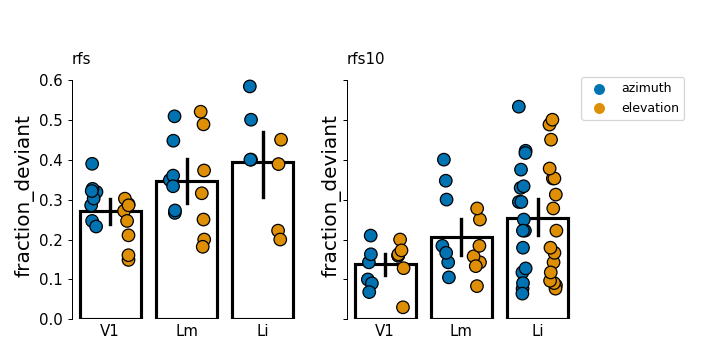

In [24]:
color1='w'
color2='k'
palette = 'colorblind'

#currdf = fraction_dev[fraction_dev['rfname']=='rfs'].copy()

fig, axes = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, fraction_dev.groupby(['experiment']))):

    
    sns.barplot("visual_area", "fraction_deviant", data=plotdf, 
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)

    sns.stripplot(x='visual_area', y='fraction_deviant', data=plotdf, 
                  ax=ax, hue='cond',
                  s=10, palette=palette, order=visual_areas, 
                  #color='w', 
                  dodge=True,
                  marker='o', edgecolor='k', linewidth=1)
                      
    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    #ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)
    
    if ai == 0:
        ax.legend_.remove()

ax.legend(bbox_to_anchor=(1.5, 1))
pl.subplots_adjust(left=0.1, right=0.8, top=0.8)

## Show individual connections for AZ v EL

<IPython.core.display.Javascript object>


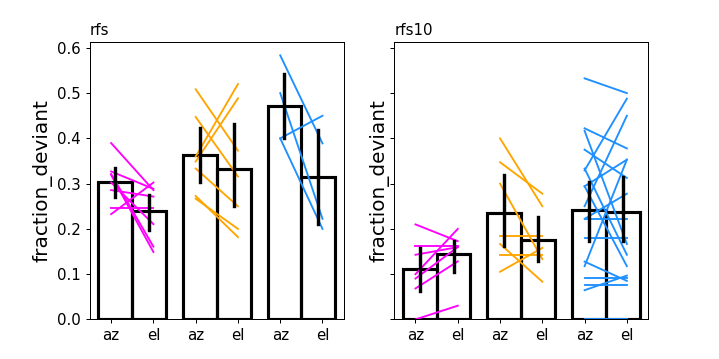

In [140]:
offset = 0.25

fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(0)

marker= 'o'
for ax, (experiment, currdf) in zip(axes.flat, fraction_dev.groupby(['experiment'])):
    aix = 0
    currdf = fraction_dev[fraction_dev['experiment']==experiment]
    for ai, visual_area in enumerate(visual_areas):
        
        plotdf = currdf[currdf['visual_area']==visual_area]
        az_vals = plotdf[plotdf['cond']=='azimuth'].sort_values(by='datakey')['fraction_deviant'].values
        el_vals = plotdf[plotdf['cond']=='elevation'].sort_values(by='datakey')['fraction_deviant'].values

        by_dset = [(a, e) for a, e in zip(az_vals, el_vals)]
        for p in by_dset:
            ax.plot([aix-offset, aix+offset], p, marker=None, color=area_colors[visual_area], alpha=1)

        aix = aix+1
    ax.set_title(experiment, loc='left', fontsize=12)

    
for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, fraction_dev.groupby(['experiment']))):

    sns.barplot("visual_area", "fraction_deviant", data=plotdf, 
                hue='cond',
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
    ax.legend_.remove()
    
    ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
    ax.set_xticklabels(['az', 'el', 'az', 'el', 'az', 'el'])
    
    ax.set_xlabel('')

## Out of how many rois that pass?

<IPython.core.display.Javascript object>


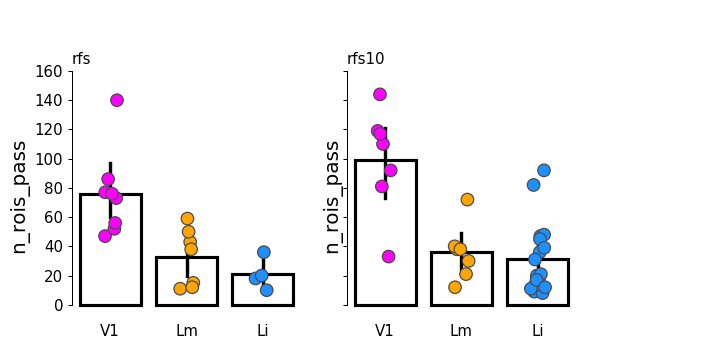

In [144]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

currdf = fraction_dev[fraction_dev['cond']=='azimuth'] # only need 1 cond

for ai, (ax, (cond, plotdf)) in enumerate(zip(axes.flat, currdf.groupby(['experiment']))):
    sns.barplot(x="visual_area", y="n_rois_pass", data=plotdf, 
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), 
                facecolor=(1,1,1,0), linewidth=2.5)
    
    sns.stripplot(x='visual_area', y='n_rois_pass', data=plotdf, 
                  ax=ax, #hue='cond',
                  s=10, palette=area_colors, order=visual_areas, 
                  #color='w', 
                  dodge=True,
                  #edgecolor=area_colors,
                  marker='o',linewidth=1)
    
     
    ax.set_ylim([-10, 160])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    #ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)
    

pl.subplots_adjust(left=0.1, right=0.8, top=0.8)

In [145]:
currdf = fraction_dev[(fraction_dev['experiment']=='rfs10')]
results = do_mannwhitney(currdf, metric='n_rois_pass')
results

Statistics=16.000, p=0.000
Different distribution (reject H0)
Statistics=38.000, p=0.000
Different distribution (reject H0)
Statistics=200.000, p=0.132
Same distribution (fail to reject H0)


[(('V1', 'Lm'), True, 0.00017260916352593831),
 (('V1', 'Li'), True, 5.7487264645865559e-06),
 (('Lm', 'Li'), False, 0.13244232910792819)]

In [146]:
currdf = fraction_dev[(fraction_dev['experiment']=='rfs')]
results = do_mannwhitney(currdf, metric='n_rois_pass')
results

Statistics=16.000, p=0.000
Different distribution (reject H0)
Statistics=0.000, p=0.000
Different distribution (reject H0)
Statistics=36.000, p=0.091
Same distribution (fail to reject H0)


[(('V1', 'Lm'), True, 0.00010484901819346983),
 (('V1', 'Li'), True, 0.00010484901819346983),
 (('Lm', 'Li'), False, 0.09092610757406816)]

In [ ]:
fig, ax = pl.subplots()


## Average rfs and rfs10

In [33]:
min_nrois = 5
average_rfs = False
i=0
avg_dev=[]

for (v, dk, cond), g in devdf.groupby(['visual_area', 'datakey', 'cond']):

    rfname = 'rfs10' if 'rfs10' in g['experiment'].unique() else 'rfs'
    if g[g['experiment']==rfname]['n_rois_pass'].unique()[0] < min_nrois \
    or g[g['experiment']==rfname]['deviants'].unique()[0]==None:
        #print(dk)
        continue

    #frac_dev = g[g['rfname']==rfname].shape[0] / g[g['rfname']==rfname]['n_rois_pass'].unique()[0]

    if 'rfs' in g['experiment'].unique() and 'rfs10' in g['experiment'].unique():
        rfs10_nrois = g[g['experiment']=='rfs10']['n_rois_pass'].unique()[0]
        rfs_nrois = g[g['experiment']=='rfs']['n_rois_pass'].unique()[0]

        frac_dev1 = float(len(g[g['experiment']=='rfs10']['deviants'].unique())) / rfs10_nrois
        frac_dev2 = float(len(g[g['experiment']=='rfs']['deviants'].unique())) / rfs_nrois

        frac_dev = np.mean([frac_dev1, frac_dev2])
        nrois_pass = np.mean([rfs10_nrois, rfs_nrois])
    else:
        frac_dev = float(len(g['deviants'].unique())) / g['n_rois_pass'].unique()[0]
        nrois_pass = g['n_rois_pass'].unique()[0]
        
    avg_dev.append(pd.DataFrame({'visual_area': v,
                                 'datakey': dk,
                                 'cond': cond,
                                 'fraction_deviant': frac_dev,
                                 'n_rois_pass': nrois_pass}, index=[i]))
    i+=1

avg_dev = pd.concat(avg_dev, axis=0).reset_index(drop=True)
    


In [34]:
avg_dev[avg_dev['fraction_deviant']==avg_dev['fraction_deviant'].min()]


,cond,datakey,fraction_deviant,n_rois_pass,visual_area
76,azimuth,20191004_JC110_fov2,0.051282,117.0,V1


In [35]:
avg_dev[avg_dev['datakey']=='20191004_JC110_fov2']

,cond,datakey,fraction_deviant,n_rois_pass,visual_area
76,azimuth,20191004_JC110_fov2,0.051282,117.0,V1
77,elevation,20191004_JC110_fov2,0.128205,117.0,V1


In [36]:
devdf[devdf['datakey']=='20191004_JC110_fov2']

,cond,datakey,deviants,experiment,n_rois,n_rois_pass,visual_area
1194,elevation,20191004_JC110_fov2,27,rfs10,118,117,V1
1195,elevation,20191004_JC110_fov2,35,rfs10,118,117,V1
1196,elevation,20191004_JC110_fov2,42,rfs10,118,117,V1
1197,elevation,20191004_JC110_fov2,52,rfs10,118,117,V1
1198,elevation,20191004_JC110_fov2,56,rfs10,118,117,V1
1199,elevation,20191004_JC110_fov2,71,rfs10,118,117,V1
1200,elevation,20191004_JC110_fov2,90,rfs10,118,117,V1
1201,elevation,20191004_JC110_fov2,97,rfs10,118,117,V1
1202,elevation,20191004_JC110_fov2,129,rfs10,118,117,V1
1203,elevation,20191004_JC110_fov2,174,rfs10,118,117,V1


In [37]:
sdata[sdata['animalid']=='JC110']


NameError: name 'sdata' is not defined

In [39]:
avg_dev.head()

,cond,datakey,fraction_deviant,n_rois_pass,visual_area
0,azimuth,20190502_JC076_fov1,0.555556,18.0,Li
1,elevation,20190502_JC076_fov1,0.166667,18.0,Li
2,azimuth,20190522_JC089_fov1,0.611111,5.0,Li
3,elevation,20190522_JC089_fov1,0.611111,5.0,Li
4,azimuth,20190527_JC092_fov2,0.117647,17.0,Li


<IPython.core.display.Javascript object>


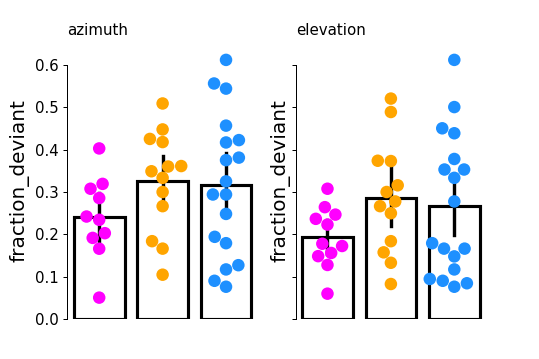

In [38]:

fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)

for ax, (cond, plotdf) in zip(axes.flat, avg_dev.groupby(['cond'])):
    sns.barplot("visual_area", "fraction_deviant", data=plotdf, ax=ax, order=visual_areas,
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    sns.swarmplot(x='visual_area', y='fraction_deviant', data=plotdf, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(cond, loc='left', fontsize=12)

In [198]:
c1 = fraction_dev[fraction_dev['visual_area']=='V1']['fraction_deviant'].values
c2 = fraction_dev[fraction_dev['visual_area']=='Lm']['fraction_deviant'].values
c3 = fraction_dev[fraction_dev['visual_area']=='Li']['fraction_deviant'].values

# Shapiro-Wilk normality test 
print(spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))


F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

((0.9737732410430908, 0.6466492414474487), (0.9297449588775635, 0.09621530771255493), (0.8193102478981018, 2.516557742637815e-06))
LeveneResult(statistic=3.3774655438715868, pvalue=0.038032346784845045)
F statistic = 1.290 and probability p = 0.280
(104,)
(104,)
(104,)
(104,)
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm   -0.0287  -0.1307 0.0734 False 
  Li     V1   -0.0639  -0.1588 0.031  False 
  Lm     V1   -0.0352  -0.1478 0.0773 False 
--------------------------------------------


<IPython.core.display.Javascript object>


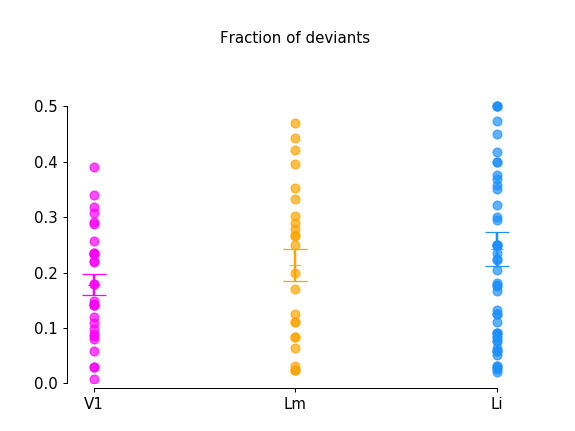

Text(0.5,1,u'Fraction of deviants')

In [173]:
fig, ax = pl.subplots()
vi = 0
for visual_area in visual_areas:
    g = fraction_dev[fraction_dev['visual_area']==visual_area]
    values = g['fraction_deviant'].values
    ax.scatter([vi for _ in range(len(values))], values,  marker='o', alpha=0.7, s=50,
               color=area_colors[visual_area])
              #edgecolor=area_colors[visual_area], facecolor='none')
        
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], linewidth=2, markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10, lw=2)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
    vi += 1
ax.set_ylim([0, .6])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

#pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

In [202]:
fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)


for ax, (rfname, g) in zip(axes.flat, fraction_dev.groupby(['rfname'])):
    sns.barplot(x="visual_area", y="fraction_deviant", data=g, 
                ax=ax, order=visual_areas, col='cond',
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    sns.swarmplot(x='visual_area', y='fraction_deviant', data=g, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    #ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(rfname, loc='left', fontsize=12)


<IPython.core.display.Javascript object>

AttributeError: Unknown property col

In [201]:
fraction_dev[fraction_dev['rfname']=='rfs10']


,visual_area,datakey,cond,rfname,n_rois,n_rois_pass,fraction_deviant
4,Li,20190522_JC089_fov1,azimuth,rfs10,11,9,0.222222
5,Li,20190522_JC089_fov1,elevation,rfs10,11,9,0.111111
6,Li,20190527_JC092_fov2,azimuth,rfs10,17,17,0.058824
7,Li,20190527_JC092_fov2,elevation,rfs10,17,17,0.058824
8,Li,20190527_JC092_fov3,azimuth,rfs10,48,47,0.063830
9,Li,20190527_JC092_fov3,elevation,rfs10,48,47,0.021277
10,Li,20190528_JC092_fov1,azimuth,rfs10,8,8,0.125000
11,Li,20190528_JC092_fov1,elevation,rfs10,8,8,0.125000
14,Li,20190602_JC091_fov1,azimuth,rfs10,90,84,0.250000
15,Li,20190602_JC091_fov1,elevation,rfs10,90,84,0.357143


In [175]:
fraction_dev.head()

,visual_area,datakey,rfname,n_rois,n_rois_pass,fraction_deviant
0,Li,20190502_JC076_fov1,rfs,21,18,0.500000
1,Li,20190502_JC076_fov1,rfs,21,18,0.166667
2,Li,20190522_JC089_fov1,rfs,3,1,1.000000
3,Li,20190522_JC089_fov1,rfs,3,1,1.000000
4,Li,20190522_JC089_fov1,rfs10,11,9,0.222222


In [ ]:
fig, axes = pl.subplots(1, 2, figsize=(6,4), sharex=True, sharey=True)
fig.patch.set_alpha(0)


for ax, (rfname, g) in zip(axes.flat, fraction_dev.groupby(['rfname'])):
    sns.barplot("visual_area", "fraction_deviant", data=g, ax=ax, order=visual_areas,
                     errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)


    sns.swarmplot(x='visual_area', y='fraction_deviant', data=g, ax=ax, 
                  palette=area_colors, s=10, marker='o', order=visual_areas) #palette=area_colors)

    ax.set_ylim([-0.05, 0.601])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')
    ax.set_xticklabels('')
    ax.patch.set_alpha(0)
    ax.set_title(rfname, loc='left', fontsize=12)


In [16]:
def get_rfdata(sdata, fit_desc=None, excluded_sessions=[]):
    assert fit_desc is not None, "No fit-desc specified!"
    
    rfdata = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]
    for skey in excluded_sessions:
        animalid, session = skey.split('-')
        drop_ixs = rfdata[(rfdata['animalid']==animalid) & (rfdata['session']==session)].index.tolist()
        rfdata= rfdata.drop(drop_ixs)
            
    fit_these = []
    dpaths = {}
    unknown = []
    for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']): #animalid in rfdata['animalid'].unique():
        skey = '-'.join([animalid, session])
        if skey in excluded_sessions:
            continue

        rfruns = g['experiment'].unique()

        for rfname in rfruns:
            if int(session) < 20190511:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_gratings*', 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            else:
                fpath = glob.glob(os.path.join(rootdir, animalid, session, '*%s' % fov, 
                                            'combined_%s_*' % rfname, 'traces', '%s*' % traceid, 
                                            'receptive_fields', fit_desc, 'fit_results.pkl'))
            if len(fpath) > 0:
                assert len(fpath)==1, "TOo many paths: %s" % str(fpath)
                dpaths['-'.join([animalid, session, fov, rfname])] = fpath[0]
                
            elif len(fpath) == 0:
                fit_these.append((animalid, session, fov, rfname))
            else:
                unknown.append((animalid, session, fov, rfname))
#     nostats = []
#     for (animalid, session, fov, run_name) in fit_these:
#         nostats = resp.visualize_session_stats(animalid, session, fov, altdir=aggregate_session_dir, create_new=True)

    print ("N dpaths: %i, N unfit: %i, N unknown: %i" % (len(dpaths), len(fit_these), len(unknown)))
    print("--- these needs fits: ---")
    for fd in fit_these:
        print(fd)
    print("N datasets included: %i, N sessions excluded: %i" % (rfdata.shape[0], len(excluded_sessions)))
    #assert (len(dpaths) + len(fit_these) + len(unknown)) == rfdata.shape[0] - len(excluded_sessions), "There are dsets unaccounted for..."
    
    rfdata = rfdata.reset_index()
    fillpaths = ['' for _ in range(rfdata.shape[0])]
    for skey, fpath in dpaths.items():
        animalid, session, fov, rfname = skey.split('-')
        df_ix = rfdata[ (rfdata['animalid']==animalid) \
                           & (rfdata['session']==session) \
                           & (rfdata['fov']==fov) \
                           & (rfdata['experiment']==rfname)].index.tolist()[0]
        fillpaths[df_ix] = fpath
        
    rfdata['path'] = fillpaths
    
    return rfdata #, nostats

In [17]:
rfdata = get_rfdata(dsets, fit_desc=fit_desc, excluded_sessions=excluded_sessions)

ValueError: need more than 1 value to unpack

In [39]:
rfdata.head()

,index,animalid,experiment,fov,session,visual_area,fovnum,path
0,136,JC078,rfs,FOV1_zoom2p0x,20190513,Lm,1,/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0...
1,143,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,1,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
2,160,JC083,rfs,FOV1_zoom2p0x,20190511,V1,1,/n/coxfs01/2p-data/JC083/20190511/FOV1_zoom2p0...
3,164,JC083,rfs,FOV1_zoom2p0x,20190512,Lm,1,/n/coxfs01/2p-data/JC083/20190512/FOV1_zoom2p0...
4,168,JC083,rfs,FOV1_zoom2p0x,20190517,Lm,1,/n/coxfs01/2p-data/JC083/20190517/FOV1_zoom2p0...


In [40]:
rfdata.iloc[0]['path']

'/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_159d37_traces001_a4a501_traces001_c64954_traces001_3d2f87_traces001_8bf55a_traces001_ac819e/receptive_fields/fit-2dgaus_dff-no-cutoff/fit_results.pkl'

In [18]:

def regplot(x, y, data=None, x_estimator=None, x_bins=None, x_ci="ci",
            scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None,
            order=1, logistic=False, lowess=False, robust=False,
            logx=False, x_partial=None, y_partial=None,
            truncate=False, dropna=True, x_jitter=None, y_jitter=None,
            label=None, color=None, marker="o",
            scatter_kws=None, line_kws=None, ax=None):

    plotter = sns.regression._RegressionPlotter(x, y, data, x_estimator, x_bins, x_ci,
                                 scatter, fit_reg, ci, n_boot, units,
                                 order, logistic, lowess, robust, logx,
                                 x_partial, y_partial, truncate, dropna,
                                 x_jitter, y_jitter, color, label)

    if ax is None:
        ax = pl.gca()

    scatter_kws = {} if scatter_kws is None else copy.copy(scatter_kws)
    scatter_kws["marker"] = marker
    line_kws = {} if line_kws is None else copy.copy(line_kws)
    plotter.plot(ax, scatter_kws, line_kws)
    return ax, plotter




def do_regr_on_fov(bootdata, bootcis, posdf, cond='azimuth', ci=.95, xaxis_lim=None):
    
    fig, ax = pl.subplots(figsize=(10,8))
    
    ax.set_title(cond)
    ax.set_ylabel('RF position (rel. deg.)')
    ax.set_xlabel('FOV position (um)')
    if xaxis_lim is not None:
        ax.set_xlim([0, xaxis_lim])
    
    axname = 'xpos' if cond=='azimuth' else 'ypos'
    parname = 'x0' if cond=='azimuth' else 'y0'
    
    # Get lis of cells that pass boot
    roi_list = [k for k, g in bootdata.groupby(['cell'])]  
    
    # Identify which cells fail...
    fail_rois = [r for r in posdf.index.tolist() if r not in roi_list]
    fadedf = posdf.loc[fail_rois]
    sns.regplot('%s_fov' % axname, '%s_rf' % axname, data=fadedf, color='k', marker='x', fit_reg=False,
                scatter_kws=dict(s=10, alpha=0.1), ax=ax, label='no fit')

    # Plot successes and regression with CI
    ax, plotter = regplot('%s_fov' % axname, '%s_rf' % axname, data=posdf.loc[roi_list], ci=ci*100, 
                          color='k', marker='o',
                scatter_kws=dict(s=8, alpha=.7), ax=ax, label='measured (regr: %i%% CI)' % int(ci*100) )

    # Get CIs from regression fit to "good data"
    grid, yhat, err_bands = plotter.fit_regression(grid=plotter.x)
    e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
    e2 = err_bands[1, :] #err_bands[1, np.argsort(xvals)]
    regr_cis = np.array([(ex, ey) for ex, ey in zip(e1, e2)])
    
    # Get rois sorted by position:
    x0_meds = np.array([g[parname].mean() for k, g in bootdata.groupby(['cell'])])
    x0_lower = bootcis['%s_lower' % parname][roi_list]
    x0_upper = bootcis['%s_upper' % parname][roi_list]

    ci_intervals = bootcis['x0_upper'] - bootcis['x0_lower']
    weird = [i for i in ci_intervals.index.tolist() if ci_intervals[i] > 10]
    print(len(weird))
    rlist = [i for i in roi_list if i not in weird]
    roi_ixs = np.array([roi_list.index(i) for i in rlist])
    roi_list = np.array([i for i in roi_list if i not in weird])
    #print(regr_cis[roi_ixs])

    xvals = posdf['%s_fov' % axname][roi_list].values
    yvals = posdf['%s_rf' % axname][roi_list].values
    
    # Plot bootstrap results    
    ax.scatter(xvals, x0_meds[roi_ixs], c='k', marker='_', alpha=0.7, 
               label='bootstrapped (%i%% CI)' % int(ci*100) )
    ax.errorbar(xvals, x0_meds[roi_ixs], yerr=np.array(zip(x0_meds[roi_ixs]-x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs]-x0_meds[roi_ixs])).T, 
            fmt='none', color='k', alpha=0.7, lw=1)
    
    if xaxis_lim is not None:
        ax.set_xticks(np.arange(0, xaxis_lim, 100))
        
    #ax.set_ylim([-10, 40])
    sns.despine(offset=4, trim=True, ax=ax)
    ax.legend()

    # Check that values make sense
    deviants = []
    bad_fits = []
    for roi,lo,up,(regL, regU), med in zip(roi_list, x0_lower.iloc[roi_ixs], x0_upper.iloc[roi_ixs], regr_cis[roi_ixs], yvals):
        if (lo <= med <= up):
            if ((regL > lo and regL > up) or (regU < lo and regU < up)):
                #print(lo, med, up)
                xv = posdf['%s_fov' % axname][roi]
                yv = posdf['%s_rf' % axname][roi]
                ax.plot(xv, yv, marker='o', markersize=5, color='magenta', alpha=0.8)
                ax.plot(xv, yv, marker='x', markersize=5, color='magenta', alpha=1.0)
                deviants.append(roi)
        else:
            # Measured not within CIs
            bad_fits.append(roi)
   
    return fig, regr_cis, deviants, bad_fits


# Plot 1 fov

In [ ]:
        exp = util.ReceptiveFields(rfname, animalid, session, fov,
                                   traceid=traceid) #, trace_type='dff')
        statsdir, stats_desc = util.create_stats_dir(exp.animalid, exp.session, exp.fov,
                                                      traceid=exp.traceid, trace_type=exp.trace_type,
                                                      response_type=response_type, 
                                                      responsive_test=None, responsive_thr=0)

        if not os.path.exists(os.path.join(statsdir, 'receptive_fields')):
            os.makedirs(os.path.join(statsdir, 'receptive_fields'))
        print("Saving stats output to: %s" % statsdir)    


        #%%
        # Get output dir for stats
        try:
            estats = exp.get_stats(response_type=response_type, fit_thr=fit_thr) # estats.rois = list of all cells that pass fit-thr
        except Exception as e:
            d_errors.append(datakey)
            continue
            
        rfdf = estats.fits
        fovinfo = estats.fovinfo
        rois_rfs = rfdf.index.tolist()

        # Get RF dir for current fit type         
        rfdir, fit_desc = fitrf.create_rf_dir(exp.animalid, exp.session, exp.fov, exp.name, traceid=exp.traceid,
                                        response_type=response_type, fit_thr=fit_thr)

        data_identifier = '|'.join([animalid, session, fov, traceid, exp.rois, exp.trace_type, fit_desc])

        # Get bootstrap results for evaluated RFs
        bootresults = evalrfs.evaluate_rfs(estats, rfdir=rfdir, 
                                           n_bootstrap_iters=n_iters, n_resamples=n_resamples,
                                           ci=ci, sigma_scale=sigma_scale)

<IPython.core.display.Javascript object>


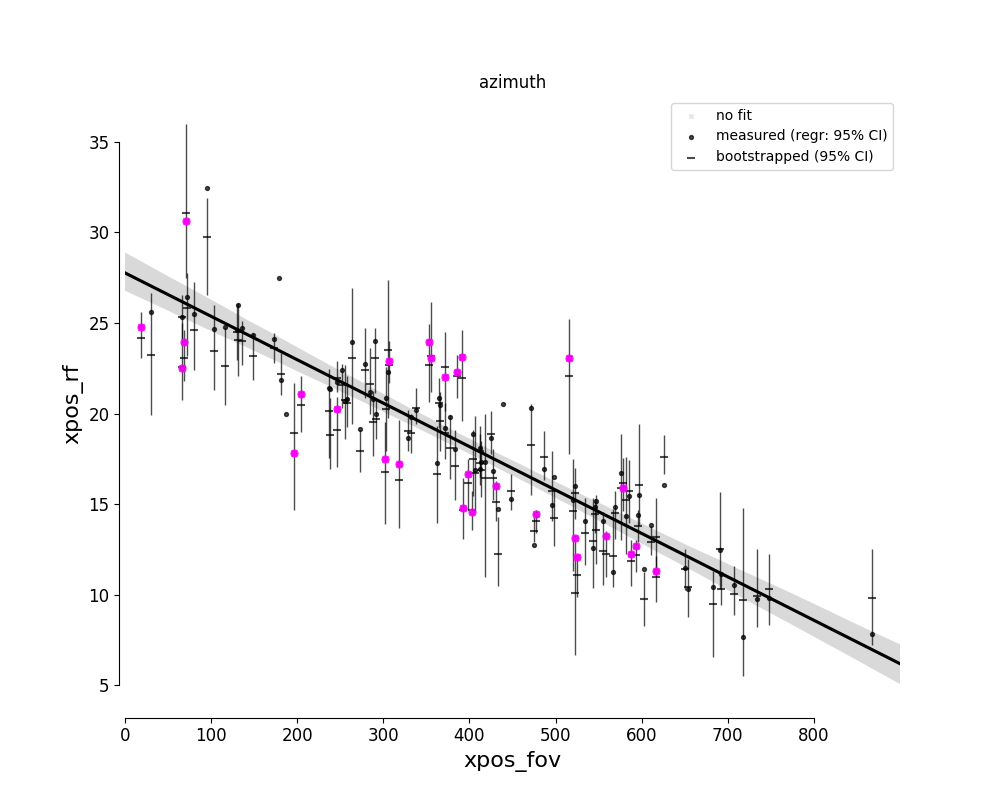

3


In [158]:
#### Calculate scatter

bootdata = bootresults['data']
bootcis = bootresults['cis']

x0_lower = bootcis['%s_lower' % parname][roi_list]
x0_upper = bootcis['%s_upper' % parname][roi_list]
for 
bootcis['x0_upper'] - bootcis['x0_lower']
    
posdf = fovinfo['positions']
xlim, ylim = fovinfo['xlim'], fovinfo['ylim']

#% # Plot bootstrapped param CIs + regression CI
xaxis_lim = max([xlim, ylim])
regresults={}


cond = 'azimuth'
fig, regr_cis, deviants, bad_fits = do_regr_on_fov(bootdata, bootcis, posdf, cond=cond, xaxis_lim=900)


In [159]:
outliers


[0,
 5,
 12,
 21,
 25,
 36,
 43,
 69,
 70,
 78,
 91,
 93,
 97,
 101,
 112,
 134,
 142,
 147,
 148,
 150,
 155,
 165,
 166,
 168,
 194,
 205,
 216,
 234]

## Compare gratings

In [161]:
fovdir = os.path.join(rootdir, animalid, session, 'FOV%i_zoom2p0x' % fovnum)
osi_niters = 1000
osi_nsamples = 20

osi_str = 'fit-dff_all-cells_boot-%i-resample-%i' % (osi_niters, osi_nsamples)
osi_dir = glob.glob(os.path.join(fovdir, 'combined_gratings_static', 'traces', '%s*' % traceid, 'tuning', osi_str))[0]

os.listdir(osi_dir)

osi_eval_dfile = os.path.join(osi_dir, 'tuning_bootstrap_evaluation.pkl')
assert os.path.exists(osi_eval_dfile), "No evaulation found! %s" % osi_dir
with open(osi_eval_dfile, 'rb') as f:
    osi_eval = pkl.load(f)


In [162]:
osi_thr = 0.6
osi_mean_iters = osi_eval['fits'].groupby(['cell']).mean()
osi_fits = osi_mean_iters[osi_mean_iters['gof']>=osi_thr]
rois_osi = osi_fits.index.tolist()
print(len(rois_osi))

82


In [164]:
matched_rois = [r for r in rois_osi if r in outliers]
matched_rois

[5, 12, 21, 25, 91, 93, 112, 142, 147, 148, 166, 205, 216]

In [ ]:
osis_with_rfs = [r for r in roi_osi if r in ]

In [166]:
len(matched_rois) / float(len(rois_osi))


0.15853658536585366

In [48]:
estats.fovinfo.keys()

['roi_contours', 'positions', 'zimg', 'ylim', 'xlim']

In [21]:
rfdata[rfdata['animalid']=='JC080']

,index,animalid,experiment,fov,session,visual_area,exp_no,animal_no,path
25,95,JC080,rfs,FOV1_zoom2p0x,20190603,Lm,3,2,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...
26,103,JC080,rfs10,FOV2_zoom2p0x,20190602,Lm,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0...
27,105,JC080,rfs10,FOV1_zoom2p0x,20190602,Li,4,2,/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0...


In [22]:
missing_rfs = []
dlist = []
for (visual_area, animalid, session, fov), g in rfdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '-'.join([visual_area, animalid, session, fov])
    #print skey
    devpath = os.path.join( os.path.split(g['path'].values[0])[0], 'evaluation', 'deviants.json')
    if not os.path.exists(devpath):
        missing_rfs.append(devpath)
        continue
    else:
        with open(devpath, 'r') as f:
            d = json.load(f)

    dev_list = [('azimuth', i) for i in d['azimuth']]
    dev_list.extend( [('elevation', i) for i in d['elevation']] )
    dev_list.extend([('pass', i) for i in d['pass_rois']])
    tmpd = pd.DataFrame({'condition': [c[0] for c in dev_list],
                         'cell': [c[1] for c in dev_list],
                         'visual_area': [visual_area for _ in range(len(dev_list))],
                         'animalid': [animalid for _ in range(len(dev_list))],
                         'session': [session for _ in range(len(dev_list))],
                         'fov': [fov for _ in range(len(dev_list))]})
    
    dlist.append(tmpd)
    

In [23]:
print(len(missing_rfs))

1


In [24]:
for f in missing_rfs:
    print f.split('/traces/')[0]

/n/coxfs01/2p-data/JC080/20190602/FOV1_zoom2p0x/combined_rfs10_static


In [25]:
print(len(dlist))

25


In [26]:
df = pd.concat(dlist, axis=0).reset_index(drop=True)


In [27]:
df.groupby(['visual_area', 'condition']).count()['cell']

visual_area  condition
Li           azimuth      120
             elevation     93
             pass         165
Lm           azimuth      144
             elevation    139
             pass         238
V1           azimuth      190
             elevation    167
             pass         611
Name: cell, dtype: int64

In [28]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [29]:
df['ratio'] = [0 for _ in range(df.shape[0])]

In [30]:
#ratios = dict((visual_area, {'azimuth': [], 'elevation': []}) for visual_area in visual_areas)
for condition in ['azimuth', 'elevation']:
    for k, g in df.groupby(['visual_area', 'animalid', 'session', 'fov']):
        npass = len(g[g['condition']=='pass'])
        nbad = len(g[g['condition']==condition])
        frac = float(nbad)/npass
        df.loc[g.index, 'ratio'] = [frac for _ in range(g.shape[0])]
        #g['fraction'] = [frac for _ in range(g.shape[0])]
        
        #ratios[k[0]][condition].append(float(nbad)/npass)
        
        

In [31]:
df

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
5,JC076,177,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
6,JC076,179,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
7,JC076,181,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
8,JC076,187,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000
9,JC076,196,azimuth,FOV1_zoom2p0x,20190502,Li,0.300000


In [32]:
for k, g in df[df['visual_area']=='Li'].groupby(['animalid', 'session']):
    print k

('JC076', '20190502')
('JC090', '20190605')
('JC091', '20190602')
('JC091', '20190614')
('JC099', '20190609')
('JC099', '20190612')
('JC099', '20190617')


<IPython.core.display.Javascript object>


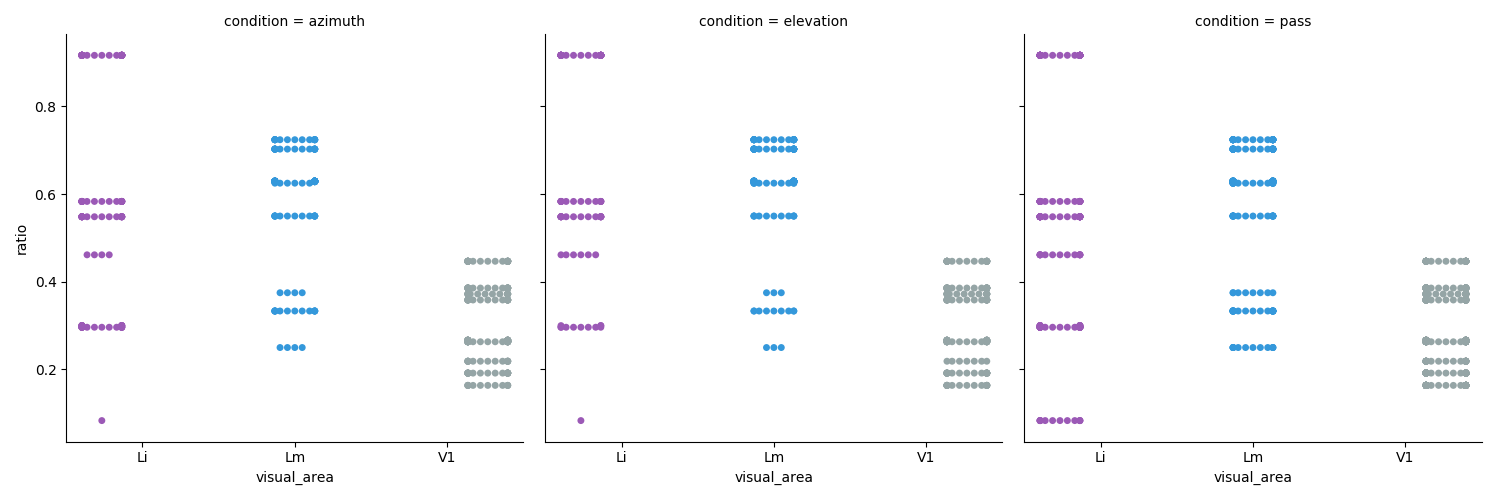

In [33]:
sns.catplot(x='visual_area', y='ratio', col='condition', hue='visual_area', data=df, \
            kind='swarm', dodge=True)

In [74]:
fracs_by_area = dict((visual_area, g.groupby(['animalid', 'session', 'fov'])['ratio'].unique().values.astype(float))\
                     for visual_area, g in df[df['condition']=='azimuth'].groupby(['visual_area']))
                     

In [75]:
df.head()

,animalid,cell,condition,fov,session,visual_area,ratio
0,JC076,7,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
1,JC076,11,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
2,JC076,120,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
3,JC076,135,azimuth,FOV1_zoom2p0x,20190502,Li,0.3
4,JC076,176,azimuth,FOV1_zoom2p0x,20190502,Li,0.3


In [94]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/scatter'

<IPython.core.display.Javascript object>


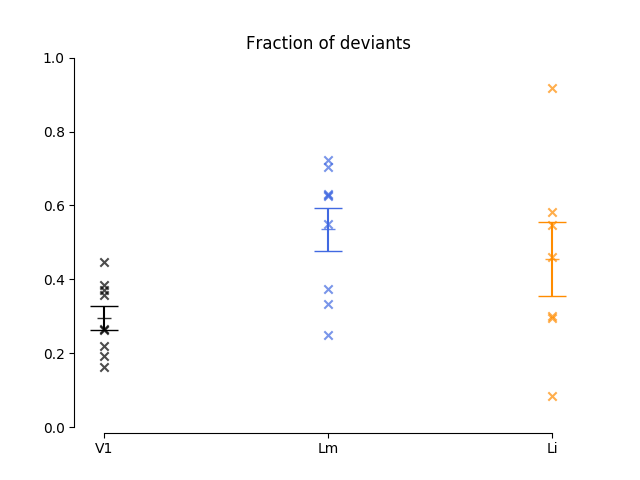

In [95]:
fig, ax = pl.subplots()

for vi, visual_area in enumerate(visual_areas):
    values = fracs_by_area[visual_area]
    ax.scatter([vi for _ in range(len(values))], values,  marker='x', color=area_colors[visual_area], alpha=0.7)
              #edgecolor=area_colors[visual_area], facecolor='none')
    ax.plot(vi, values.mean(), marker='_', color=area_colors[visual_area], markersize=10, alpha=0.8)
    ax.errorbar(vi, values.mean(), yerr=spstats.sem(values), ecolor=area_colors[visual_area], capsize=10)
    #sns.boxplot(x=[vi for _ in range(len(values))], y=values, color=area_colors[visual_area])
ax.set_ylim([0, 1])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(visual_areas)
sns.despine(ax=ax, trim=True, offset=4)

ax.set_title("Fraction of deviants")

pl.savefig(os.path.join(outdir, 'fraction_deviants.svg'))

In [40]:
g.groupby(['animalid', 'session', 'fov'])['ratio'].unique()

animalid  session   fov          
JC076     20190420  FOV1_zoom2p0x           [0.21875]
JC083     20190507  FOV1_zoom2p0x    [0.372093023256]
JC084     20190522  FOV1_zoom2p0x    [0.263157894737]
JC085     20190622  FOV1_zoom2p0x    [0.266666666667]
JC097     20190613  FOV1_zoom2p0x    [0.358490566038]
          20190615  FOV1_zoom2p0x    [0.191666666667]
                    FOV2_zoom2p0x    [0.163636363636]
          20190616  FOV1_zoom2p0x    [0.385714285714]
          20190617  FOV1_zoom2p0x    [0.446808510638]
Name: ratio, dtype: object

In [78]:
df.groupby(['visual_area', 'animalid', 'session', 'fov'])['ratio'].unique()

visual_area  animalid  session   fov          
Li           JC076     20190502  FOV1_zoom2p0x     [0.272727272727]
             JC090     20190605  FOV1_zoom2p0x    [0.0833333333333]
Lm           JC076     20190423  FOV1_zoom2p0x     [0.333333333333]
             JC078     20190426  FOV1_zoom2p0x      [0.62962962963]
                       20190430  FOV1_zoom2p0x     [0.724137931034]
                       20190513  FOV1_zoom2p0x     [0.733333333333]
             JC080     20190603  FOV1_zoom2p0x     [0.710526315789]
             JC083     20190508  FOV1_zoom2p0x     [0.611111111111]
             JC084     20190525  FOV1_zoom2p0x     [0.333333333333]
             JC091     20190627  FOV1_zoom2p0x              [0.375]
V1           JC076     20190420  FOV1_zoom2p0x     [0.266666666667]
             JC083     20190507  FOV1_zoom2p0x     [0.380952380952]
             JC084     20190522  FOV1_zoom2p0x     [0.272727272727]
             JC097     20190617  FOV1_zoom2p0x     [0.458333333333]
N